In [ ]:
%env PYTHONHASHSEED=42

!pip install pydrive                             # Package to use Google Drive API - not installed in Colab VM by default
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from google.colab import drive
ROOT_PATH = '/content/drive'
drive.mount(ROOT_PATH)
ROOT_PATH += '/My Drive/ALFABETO/'

env: PYTHONHASHSEED=42
Mounted at /content/drive


In [ ]:
import os
import numpy as np
import random
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
#os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




**AIM: predict hospitalization **

In [ ]:
import pandas as pd
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt

### Training set

In [ ]:
df_training = pd.read_excel(ROOT_PATH + 'training_con_probabilita+gravità_prognosi.xlsx',
                            index_col=0)
df_training.head()

,Bpco,CancroAttivoNegliUltimi5Anni,CardiopatiaIschemica,ComorbiditaMaggioreDue,Consolidation,Demenza,DiabeteMellitoTipo2,DifficoltaRespiratorie,Edema,Effusion,Eta,FibrillazioneAtriale,Giorni,Ictus,Infiltration,InsufficienzaRenaleCronica,InsufficienzaRespiratoria,IpertensioneArteriosa,LungOpacity,PatologieCardiovascolari,Pcr,Saturazione,ScompensoCardiaco,Sesso,Temperatura,Tosse,Wbc,Prognosi,GravitàPrognosi,Predizione,P_casa,P_ospedale
0,0.0,0.0,0.0,1.0,0.530,0.0,0.0,1.0,0.512,0.277,72,0.0,NaN,0.0,0.542,0.0,1.0,1.0,0.797,1.0,26.06,NaN,0.0,M,NaN,1.0,12.40,Hospital,2,Hospital,0.2909,0.7091
1,0.0,0.0,1.0,1.0,0.564,1.0,1.0,1.0,0.528,0.279,88,0.0,NaN,0.0,0.810,1.0,0.0,1.0,0.966,1.0,12.00,78.0,0.0,M,36.1,0.0,5.10,Hospital,2,Hospital,0.2904,0.7096
2,0.0,0.0,0.0,0.0,0.082,0.0,0.0,1.0,0.003,0.037,61,0.0,2.0,0.0,0.433,0.0,0.0,1.0,0.091,0.0,3.01,97.0,0.0,M,38.4,0.0,3.10,Home,NaN,Home,0.7106,0.2894
3,0.0,0.0,0.0,0.0,0.115,0.0,0.0,1.0,0.144,0.054,82,0.0,2.0,0.0,0.504,0.0,0.0,1.0,0.209,0.0,14.68,96.0,0.0,M,38.7,0.0,8.40,Home,NaN,Home,0.5433,0.4567
4,0.0,0.0,0.0,0.0,0.544,0.0,1.0,1.0,0.519,0.609,69,0.0,1.0,0.0,0.658,0.0,0.0,0.0,0.785,0.0,13.18,NaN,0.0,M,37.5,0.0,5.61,Hospital,1,Hospital,0.4305,0.5695


In [ ]:
df_training.shape

(594, 32)

In [ ]:
df_training = df_training.replace('Home', 0)
df_training = df_training.replace('Hospital', 1)
df_training = df_training.replace('M', 0)
df_training = df_training.replace('F', 1)

Prognosis: 
- 0 = hospitalization without CPAP 
- 1 = hospitalization with CPAP 
- 2 = hospitalization in intensive care/mechanical ventilation/death

In [ ]:
from collections import Counter
Counter(df_training['Prognosi'])

Counter({0: 301, 1: 293})

Missing data handling

In [ ]:
df_training.isna().sum()

Bpco                             15
CancroAttivoNegliUltimi5Anni     15
CardiopatiaIschemica             15
ComorbiditaMaggioreDue           15
Consolidation                     0
Demenza                          17
DiabeteMellitoTipo2              15
DifficoltaRespiratorie           12
Edema                             0
Effusion                          0
Eta                               0
FibrillazioneAtriale             21
Giorni                          100
Ictus                            22
Infiltration                      0
InsufficienzaRenaleCronica       15
InsufficienzaRespiratoria        21
IpertensioneArteriosa            15
LungOpacity                       0
PatologieCardiovascolari         17
Pcr                              16
Saturazione                     157
ScompensoCardiaco                22
Sesso                             0
Temperatura                     113
Tosse                            13
Wbc                               4
Prognosi                    

In [ ]:
# # Removal of features containing more than 90% of NaN
print("DataFrame shape before NaN removal:", df_training.shape)
df_training_nanremoved = df_training.dropna(thresh= round(df_training.shape[0] * 0.90), axis=1)
print("DataFrame shape after NaN removal:", df_training_nanremoved.shape)
display(df_training_nanremoved)

DataFrame shape before NaN removal: (594, 32)
DataFrame shape after NaN removal: (594, 28)


,Bpco,CancroAttivoNegliUltimi5Anni,CardiopatiaIschemica,ComorbiditaMaggioreDue,Consolidation,Demenza,DiabeteMellitoTipo2,DifficoltaRespiratorie,Edema,Effusion,Eta,FibrillazioneAtriale,Ictus,Infiltration,InsufficienzaRenaleCronica,InsufficienzaRespiratoria,IpertensioneArteriosa,LungOpacity,PatologieCardiovascolari,Pcr,ScompensoCardiaco,Sesso,Tosse,Wbc,Prognosi,Predizione,P_casa,P_ospedale
0,0.0,0.0,0.0,1.0,0.530,0.0,0.0,1.0,0.512,0.277,72,0.0,0.0,0.542,0.0,1.0,1.0,0.797,1.0,26.06,0.0,0,1.0,12.40,1,1,0.2909,0.7091
1,0.0,0.0,1.0,1.0,0.564,1.0,1.0,1.0,0.528,0.279,88,0.0,0.0,0.810,1.0,0.0,1.0,0.966,1.0,12.00,0.0,0,0.0,5.10,1,1,0.2904,0.7096
2,0.0,0.0,0.0,0.0,0.082,0.0,0.0,1.0,0.003,0.037,61,0.0,0.0,0.433,0.0,0.0,1.0,0.091,0.0,3.01,0.0,0,0.0,3.10,0,0,0.7106,0.2894
3,0.0,0.0,0.0,0.0,0.115,0.0,0.0,1.0,0.144,0.054,82,0.0,0.0,0.504,0.0,0.0,1.0,0.209,0.0,14.68,0.0,0,0.0,8.40,0,0,0.5433,0.4567
4,0.0,0.0,0.0,0.0,0.544,0.0,1.0,1.0,0.519,0.609,69,0.0,0.0,0.658,0.0,0.0,0.0,0.785,0.0,13.18,0.0,0,0.0,5.61,1,1,0.4305,0.5695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,0.0,0.0,1.0,1.0,0.515,1.0,0.0,1.0,0.062,0.569,82,1.0,1.0,0.432,1.0,0.0,0.0,0.693,1.0,3.28,0.0,0,0.0,10.96,1,1,0.4418,0.5582
590,0.0,0.0,0.0,0.0,0.452,0.0,1.0,1.0,0.393,0.168,62,0.0,0.0,0.296,0.0,0.0,1.0,0.500,0.0,11.52,0.0,0,1.0,7.10,1,1,0.4862,0.5138
591,0.0,1.0,0.0,0.0,0.574,0.0,0.0,0.0,0.076,0.120,68,0.0,0.0,0.646,0.0,0.0,0.0,0.860,0.0,2.80,0.0,1,1.0,3.90,0,0,0.6139,0.3861
592,NaN,NaN,NaN,NaN,0.519,NaN,NaN,1.0,0.112,0.226,81,NaN,NaN,0.516,NaN,NaN,NaN,0.585,NaN,4.04,NaN,1,0.0,6.70,0,0,0.6654,0.3346


Removed features:

In [ ]:
set(df_training.columns) ^ set(df_training_nanremoved)

{'Giorni', 'GravitàPrognosi', 'Saturazione', 'Temperatura'}

In [ ]:
# How to impute missing values
from collections import Counter
# Imputing missing values
# Categorical: the most frequent value
def impute_nan(dataset, cat_feat, num_feat):
  dataset.reset_index(drop=True, inplace=True)
  feat2impute = {}
  for c in cat_feat:
    m=Counter(dataset[c])
        #print('Feature:', c, '; Number of Nan rows:', dataset[dataset[c].isna()].shape[0])

    # m.most_common(1)[0][0]
    iNa = np.where(dataset[c].isna())[0]
    iC = np.where(dataset.columns==c)[0]
    dataset[c] = dataset[c].fillna(m.most_common(1)[0][0])
    feat2impute[c] = m.most_common(1)[0][0]
  # Non-categorical: mean
  for c in num_feat:
    m=dataset[c].mean()
    #print('Feature:', c, '; Number of Nan rows:', dataset[dataset[c].isna()].shape[0])

    # m.most_common(1)[0][0]
    iNa = np.where(dataset[c].isna())[0]
    iC = np.where(dataset.columns==c)[0]
    dataset[c] = dataset[c].fillna(m)
    feat2impute[c] = m
  return (dataset, feat2impute)

def impute_nan_test(testdata, f2impute):
  for c in testdata.columns:
    testdata[c] = testdata[c].fillna(f2impute[c]) 
  return testdata

In [ ]:
df_training = df_training_nanremoved

In [ ]:
cat_feat = ['Bpco',
            'CancroAttivoNegliUltimi5Anni',
            'CardiopatiaIschemica',
            'ComorbiditaMaggioreDue', 'Demenza',
            'DiabeteMellitoTipo2',
            'DifficoltaRespiratorie', 
            'FibrillazioneAtriale',	'Ictus',
            'InsufficienzaRenaleCronica',	
            'InsufficienzaRespiratoria',
            'IpertensioneArteriosa', 'PatologieCardiovascolari',
            'ScompensoCardiaco','Sesso', 'Tosse']

num_feat = list(set(df_training.columns) ^ set(cat_feat+['P_casa',
                                                         'P_ospedale',
                                                         'Prognosi','Predizione',
                                                         ])) 


### ML model

In [ ]:
df_training.columns

Index(['Bpco', 'CancroAttivoNegliUltimi5Anni', 'CardiopatiaIschemica',
       'ComorbiditaMaggioreDue', 'Consolidation', 'Demenza',
       'DiabeteMellitoTipo2', 'DifficoltaRespiratorie', 'Edema', 'Effusion',
       'Eta', 'FibrillazioneAtriale', 'Ictus', 'Infiltration',
       'InsufficienzaRenaleCronica', 'InsufficienzaRespiratoria',
       'IpertensioneArteriosa', 'LungOpacity', 'PatologieCardiovascolari',
       'Pcr', 'ScompensoCardiaco', 'Sesso', 'Tosse', 'Wbc', 'Prognosi',
       'Predizione', 'P_casa', 'P_ospedale'],
      dtype='object')

In [ ]:
# RandomForest
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb

featcol = num_feat + cat_feat
deepfeat = ['Consolidation', 'Edema', 'Infiltration', 'Effusion', 'LungOpacity']
X = df_training[featcol].to_numpy()
y = df_training['Prognosi'].astype(int).to_numpy()

# clf = GradientBoostingClassifier(random_state=1)

cross_val_metrics_g = dict.fromkeys(['Accuracy', 'Precision', 'Recall', 'Specificity','F_score'])
for x in cross_val_metrics_g.keys():
  cross_val_metrics_g[x] = []                         

# 3. Set the `numpy` pseudo-random generator at a fixed value

rng = np.random.RandomState(0)
kf = KFold( n_splits=10, shuffle=False, random_state=rng)
y_training_cv = []
confmats = []
test_indexes = []
prob_pred = np.empty((0,2))

for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    test_indexes.append(test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    (X_train, feat2impute_fold) = impute_nan(pd.DataFrame(X_train, columns=featcol), cat_feat, num_feat)
    X_test = impute_nan_test(pd.DataFrame(X_test, columns=featcol), 
                             feat2impute_fold)
    
    # Scaling between 0 and 1
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    #clf = GradientBoostingClassifier(random_state=1, n_estimators=500)
    #clf = LogisticRegression(random_state=1, penalty='l1', solver='liblinear')
  
    clf_kfold = RandomForestClassifier(random_state=rng,
                                 n_estimators=500,
                                 criterion='gini', n_jobs=1,
                                 min_samples_leaf=10)
    #clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
    clf_kfold.fit(X_train, y_train) 

    ypred = clf_kfold.predict(X_test)
    y_training_cv = y_training_cv + list(y_test)
    prob_pred = np.append(prob_pred, clf_kfold.predict_proba(X_test), axis=0)

    #r_i = multilabel_confusion_matrix(y_test, ypred)
    #confmats.append(r_i)
    tn, fp, fn, tp = confusion_matrix(y_test, ypred).ravel()
    cross_val_metrics_g['Accuracy'] = cross_val_metrics_g['Accuracy']  + [(tp+tn)/(tp+tn+fp+fn)]
    cross_val_metrics_g['Precision'] = cross_val_metrics_g['Precision'] +  [(tp/(tp+fp))]
    cross_val_metrics_g['Recall'] = cross_val_metrics_g['Recall'] + [ tp/(tp+fn) ]
    cross_val_metrics_g['Specificity'] = cross_val_metrics_g['Specificity'] + [tn/(tn+fp)]
    cross_val_metrics_g['F_score'] = cross_val_metrics_g['F_score'] + [f1_score(y_test, ypred)]
                                         

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
prec_training, recall_training, threshold = precision_recall_curve(df_training['Prognosi'].astype(int), 
                                                                   prob_pred[:, 1])
f_training = 2*prec_training*recall_training/(recall_training+prec_training)
print('Prec', prec_training[np.where(f_training==np.nanmax(f_training))[0]])
print('Recall', recall_training[np.where(f_training==np.nanmax(f_training))[0]])
print('Threshold', threshold[np.where(f_training==np.nanmax(f_training))[0]])
selected_threshold = threshold[np.where(f_training==np.nanmax(f_training))[0]]

Prec [0.63294118]
Recall [0.91808874]
Threshold [0.37788358]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
cross_val_metrics_mean = {}
cross_val_metrics_std = {}
for k,v in cross_val_metrics_g.items():
  cross_val_metrics_mean[k] = np.mean(v)
  cross_val_metrics_std[k] = np.std(v)

In [ ]:
cross_val_metrics_mean

{'Accuracy': 0.6817796610169491,
 'F_score': 0.6930817302896286,
 'Precision': 0.6568801164546696,
 'Recall': 0.7375728129134203,
 'Specificity': 0.6281335490999824}

In [ ]:
cross_val_metrics_std

{'Accuracy': 0.05306739842779688,
 'F_score': 0.06061765873977343,
 'Precision': 0.0604390952986136,
 'Recall': 0.08158415421922563,
 'Specificity': 0.049429786379877994}

Training on the complete training set

In [ ]:
(X_all_training, feat2impute_allt) = impute_nan(pd.DataFrame(X, columns=featcol), cat_feat, num_feat)

    # Scaling between 0 and 1
scaler = MinMaxScaler()
X_allt_norm = scaler.fit_transform(X_all_training)
clf = RandomForestClassifier(random_state=1, n_estimators=500,
                                 criterion='gini', min_samples_leaf=10)
clf.fit(X_allt_norm, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

## June 2021: third wave

In [ ]:
path_newdata = 'ALFABETO OutputModelli+Riaccessi 20210621ch.xlsx'

newdata = pd.read_excel(ROOT_PATH + path_newdata)
newdata.head()

,ID,DataNascita,Sesso,Temperatura,Giorni,Tosse,DifficoltaRespiratorie,Wbc,Pcr,Saturazione,Ferritina,PatologieCardiovascolari,CardiopatiaIschemica,FibrillazioneAtriale,ScompensoCardiaco,Ictus,IpertensioneArteriosa,DiabeteMellitoTipo2,Demenza,Bpco,CancroUltimi5Anni,InsufficienzaRenaleCronica,InsufficienzaRespiratoria,Consolidation,Edema,Effusion,Infiltration,LungOpacity,Prognosi,Predizione,ProbabilitaClinica,Riaccesso,Numero Riaccessi,Giorni tra primo e ultimo riaccesso,Prognosi Ultimo Riaccesso,Predizione Ultimo Riaccesso,ProbabilitaClinica Ultimo Riaccesso
0,1,1955-03-25T00:00:00.0000000,M,36.0,NaN,True,False,3.61,1.07,99.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,0.287,0.126,0.110,0.525,0.517,Home,Home,0.759646,No,NaN,NaN,NaN,NaN,NaN
1,2,1973-06-08T00:00:00.0000000,M,NaN,3.0,False,False,3.67,1.70,98.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,0.109,0.243,0.078,0.504,0.249,Home,Home,0.741989,Yes,1.0,3.0,Hospital,Home,0.539318
2,3,1936-05-22T00:00:00.0000000,M,37.3,NaN,False,False,1.68,2.21,98.0,NaN,False,False,False,False,False,True,False,False,True,False,False,True,0.137,0.229,0.047,0.551,0.373,Hospital,Home,0.695750,No,NaN,NaN,NaN,NaN,NaN
3,4,1942-08-16T00:00:00.0000000,F,36.0,NaN,False,True,5.60,6.81,97.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,0.543,0.510,0.335,0.608,0.873,Hospital,Home,0.614042,No,NaN,NaN,NaN,NaN,NaN
4,5,1938-07-25T00:00:00.0000000,F,36.0,3.0,True,False,2.90,7.14,93.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,0.510,0.484,0.543,0.580,0.609,Home,Home,0.660945,Yes,1.0,2.0,Hospital,Home,0.614383


In [ ]:
newdata = newdata.rename(columns={'CancroUltimi5Anni':'CancroAttivoNegliUltimi5Anni'})

In [ ]:
newdata.shape

(462, 37)

In [ ]:
newdata['Sesso'].value_counts()

M    266
F    196
Name: Sesso, dtype: int64

In [ ]:
newdata['ComorbiditaMaggioreDue'].value_counts()

False    437
True      25
Name: ComorbiditaMaggioreDue, dtype: int64

In [ ]:
np.std(newdata['Eta'])

15.328827060081084

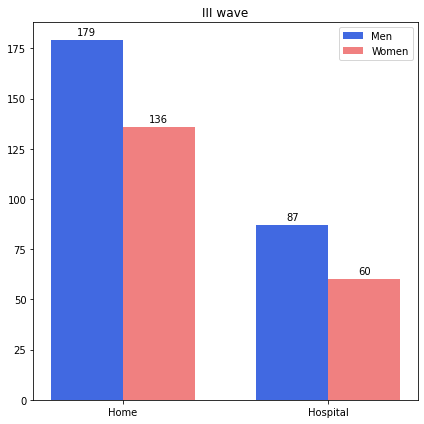

In [ ]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        

labels = ['Home', 'Hospital']
# Two values: # of male (or female) in class 0, # of male (or female) in class 1
men_iii= newdata[newdata['Sesso']=='M']['Prognosi'].value_counts() 
women_iii = newdata[newdata['Sesso']=='F']['Prognosi'].value_counts() 

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(6,6))
rects1 = ax.bar(x - width/2, men_iii, width, label='Men', color='royalblue')
rects2 = ax.bar(x + width/2, women_iii, width, label='Women', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('III wave')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()





autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

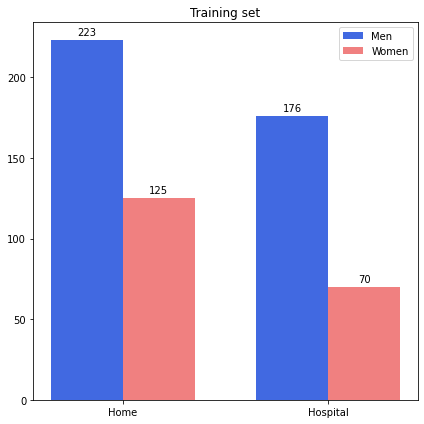

In [ ]:


labels = ['Home', 'Hospital']
# Two values: # of male (or female) in class 0, # of male (or female) in class 1
men_iii= df_training[df_training['Sesso']==0]['Prognosi'].value_counts() 
women_iii = df_training[df_training['Sesso']==1]['Prognosi'].value_counts() 

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(6,6))
rects1 = ax.bar(x - width/2, men_iii, width, label='Men', color='royalblue')
rects2 = ax.bar(x + width/2, women_iii, width, label='Women', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Training set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()





autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Creo la colonna comorb >2

In [ ]:
comorb_feat = ['PatologieCardiovascolari', 'CardiopatiaIschemica', 'FibrillazioneAtriale',
               'ScompensoCardiaco', 'Ictus', 'IpertensioneArteriosa', 'DiabeteMellitoTipo2',
               'Demenza', 'Bpco', 'CancroAttivoNegliUltimi5Anni', 'InsufficienzaRenaleCronica',
               'InsufficienzaRespiratoria']
newdata['ComorbiditaMaggioreDue'] = newdata[comorb_feat].astype(int).sum(axis=1)>2

In [ ]:
y_true_newdata = [int(x=='Hospital') for x in newdata['Prognosi']]
y_test_newdata = [int(x=='Hospital') for x in newdata['Predizione']]
yprob_class_alfabeto = [x for x in newdata['ProbabilitaClinica']] # probabilità della classe predetta

probpred_hosp = [0]*len(y_test_newdata)
probpred_home = [0]*len(y_test_newdata)

for i,x in enumerate(yprob_class_alfabeto):
  if y_test_newdata[i]==1:
    probpred_hosp[i] = x
    probpred_home[i] = 1-x
  else:
    probpred_hosp[i] = 1-x
    probpred_home[i] = x

newdata['Prob_Hosp'] = probpred_hosp
newdata['Prob_Home'] = probpred_home

newdata

,ID,DataNascita,Sesso,Temperatura,Giorni,Tosse,DifficoltaRespiratorie,Wbc,Pcr,Saturazione,Ferritina,PatologieCardiovascolari,CardiopatiaIschemica,FibrillazioneAtriale,ScompensoCardiaco,Ictus,IpertensioneArteriosa,DiabeteMellitoTipo2,Demenza,Bpco,CancroAttivoNegliUltimi5Anni,InsufficienzaRenaleCronica,InsufficienzaRespiratoria,Consolidation,Edema,Effusion,Infiltration,LungOpacity,Prognosi,Predizione,ProbabilitaClinica,Riaccesso,Numero Riaccessi,Giorni tra primo e ultimo riaccesso,Prognosi Ultimo Riaccesso,Predizione Ultimo Riaccesso,ProbabilitaClinica Ultimo Riaccesso,Eta,ComorbiditaMaggioreDue,Prob_Hosp,Prob_Home
0,1,1955-03-25T00:00:00.0000000,M,36.0,NaN,True,False,3.61,1.07,99.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,0.287,0.126,0.110,0.525,0.517,Home,Home,0.759646,No,NaN,NaN,NaN,NaN,NaN,67,False,0.240354,0.759646
1,2,1973-06-08T00:00:00.0000000,M,NaN,3.0,False,False,3.67,1.70,98.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,0.109,0.243,0.078,0.504,0.249,Home,Home,0.741989,Yes,1.0,3.0,Hospital,Home,0.539318,48,False,0.258011,0.741989
2,3,1936-05-22T00:00:00.0000000,M,37.3,NaN,False,False,1.68,2.21,98.0,NaN,False,False,False,False,False,True,False,False,True,False,False,True,0.137,0.229,0.047,0.551,0.373,Hospital,Home,0.695750,No,NaN,NaN,NaN,NaN,NaN,85,True,0.304250,0.695750
3,4,1942-08-16T00:00:00.0000000,F,36.0,NaN,False,True,5.60,6.81,97.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,0.543,0.510,0.335,0.608,0.873,Hospital,Home,0.614042,No,NaN,NaN,NaN,NaN,NaN,79,False,0.385958,0.614042
4,5,1938-07-25T00:00:00.0000000,F,36.0,3.0,True,False,2.90,7.14,93.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,0.510,0.484,0.543,0.580,0.609,Home,Home,0.660945,Yes,1.0,2.0,Hospital,Home,0.614383,83,False,0.339055,0.660945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,496,1979-06-27T00:00:00.0000000,M,NaN,NaN,False,False,10.62,16.92,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,0.675,0.593,0.534,0.656,0.878,Hospital,Hospital,0.618361,No,NaN,NaN,NaN,NaN,NaN,42,False,0.618361,0.381639
458,497,1967-02-03T00:00:00.0000000,M,37.9,NaN,False,False,9.67,19.74,92.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,0.546,0.509,0.225,0.632,0.781,Hospital,Hospital,0.586411,No,NaN,NaN,NaN,NaN,NaN,55,False,0.586411,0.413589
459,498,1938-06-18T00:00:00.0000000,M,36.5,2.0,True,True,4.80,12.44,85.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,0.576,0.513,0.590,0.661,0.890,Hospital,Hospital,0.577562,No,NaN,NaN,NaN,NaN,NaN,83,False,0.577562,0.422438
460,499,1938-05-02T00:00:00.0000000,M,38.2,3.0,False,False,6.30,5.17,96.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,0.124,0.074,0.066,0.516,0.177,Hospital,Home,0.683699,No,NaN,NaN,NaN,NaN,NaN,84,False,0.316301,0.683699


Comorbidities comparison

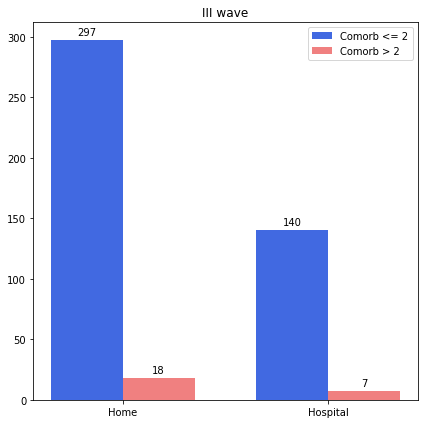

In [ ]:

nocomorb= newdata[newdata['ComorbiditaMaggioreDue']==False]['Prognosi'].value_counts() 
comorb = newdata[newdata['ComorbiditaMaggioreDue']==True]['Prognosi'].value_counts() 

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(6,6))
rects1 = ax.bar(x - width/2, nocomorb, width, label='Comorb <= 2', color='royalblue')
rects2 = ax.bar(x + width/2, comorb, width, label='Comorb > 2', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('III wave')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()





autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

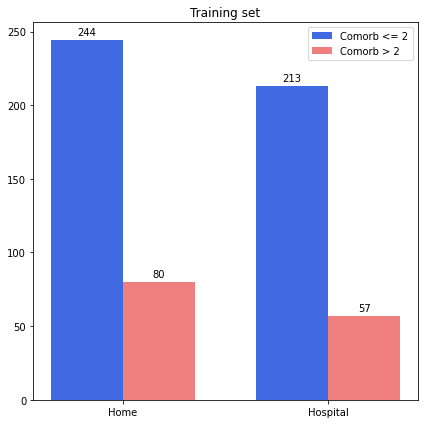

In [ ]:
nocomorb= df_training[df_training['ComorbiditaMaggioreDue']==0]['Prognosi'].value_counts() 
comorb = df_training[df_training['ComorbiditaMaggioreDue']==1]['Prognosi'].value_counts() 

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(6,6))
rects1 = ax.bar(x - width/2, nocomorb, width, label='Comorb <= 2', color='royalblue')
rects2 = ax.bar(x + width/2, comorb, width, label='Comorb > 2', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Training set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()





autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

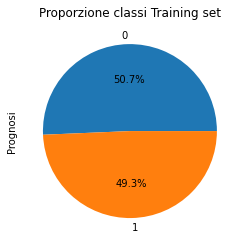

In [ ]:
training_class = df_training.groupby("Prognosi")["Prognosi"].count()
training_class.plot.pie(autopct="%.1f%%", title='Proporzione classi Training set')

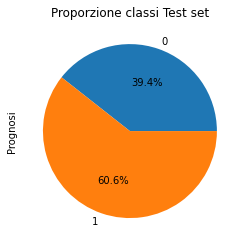

In [ ]:
test_class = df_test.groupby("Prognosi")["Prognosi"].count()
test_class.plot.pie(autopct="%.1f%%", title='Proporzione classi Test set')

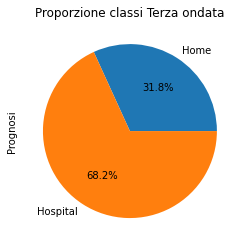

In [ ]:
terzaond_class = newdata.groupby("Prognosi")["Prognosi"].count()
terzaond_class.plot.pie(autopct="%.1f%%", title='Proporzione classi Terza ondata')

#### Prediction III wave

In [ ]:
terzaond_dataset = newdata[featcol]

terzaond_dataset = terzaond_dataset.replace('M', 0)
terzaond_dataset = terzaond_dataset.replace('F', 1)

# Data Transformation
dataset_III = impute_nan_test(terzaond_dataset, 
                             feat2impute_allt)
dataset_III_norm = scaler.transform(dataset_III)

# Prediction
y_pred_III = clf.predict(dataset_III_norm)

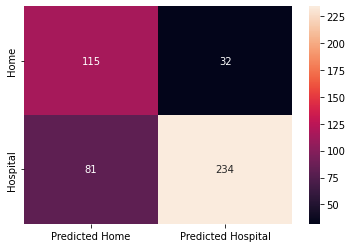

In [ ]:
y_pred_proba = clf.predict_proba(dataset_III_norm)
y_III_new = (y_pred_proba[:, 1]>=selected_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true_newdata, y_III_new).ravel()

confmat_newmod = pd.DataFrame(data=np.array([[tn, fp], [fn, tp]]), index=['Home', 'Hospital'], 
                       columns=['Predicted Home', 'Predicted Hospital'])
sns.heatmap(confmat_newmod, annot=True, fmt='d')

Text(0.5, 1.0, 'Performance III ondata RF (Hospital target, threshold 0.36)')

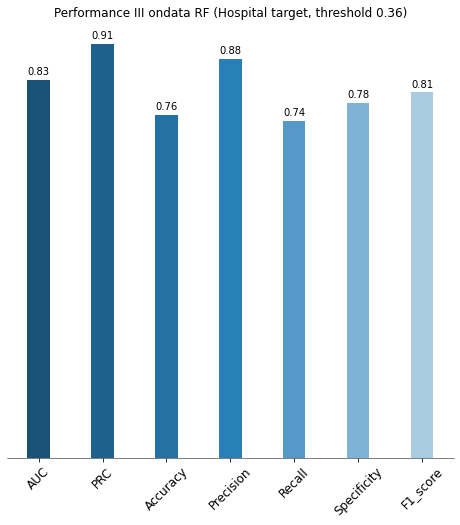

In [ ]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:0.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

labels = ['AUC', 'PRC', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1_score']
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(8,8))
ax.spines["bottom"].set_lw(0.5)  
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
r = ax.bar(x, [roc_auc_score(y_true_newdata, y_pred_proba[:,1]),
               average_precision_score(y_true_newdata, y_pred_proba[:,1]), 
               accuracy_score(y_true_newdata, y_III_new), 
               precision_score(y_true_newdata, y_III_new), 
               recall_score(y_true_newdata, y_III_new), 
               tn/(tn+fp),
               f1_score(y_true_newdata, y_III_new)], width = 0.35, 
           label=labels, color=['#1a5276', '#1f618d', '#2471a3', '#2980b9', '#5499c7', '#7fb3d5', '#a9cce3' ])
ax.set_ylabel('Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, fontsize=12)
ax.yaxis.set_visible(False)
autolabel(r)
plt.title('Performance III ondata RF (Hospital target, threshold 0.36)', fontsize=12)
#plt.show()
#plt.savefig(ROOT_PATH + 'alfabeto_testset_metrics_averaged_thr05.png', dpi=300)
